# Quality Control Reports

Create a report quality checking an individual unit.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from collections import Counter
from pynwb import NWBHDF5IO

import numpy as np
import matplotlib.pyplot as plt

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.measures import compute_firing_rate
from spiketools.utils import set_random_seed
from spiketools.utils.extract import get_range
from spiketools.utils.epoch import (epoch_spikes_by_range, epoch_spikes_by_event)


In [3]:
import sys
sys.path.append('../code')
from reports import *
from plts import plot_spikes_trial

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
BASE_PATH = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH/')
DATA_PATH = BASE_PATH / 'NWB'

PATHS = {
    'BASE' : BASE_PATH,
    'DATA' : DATA_PATH
}

In [6]:
# Define the base data folder
data_folder = '/Users/Claire_han/Documents/Data/JacobsLab/TH/NWB'
#data_folder = '/scratch/tom.donoghue/TH/'

In [7]:
# Define session information
session = {
    'experiment' : 'THO',
    'subject' : 'wv001',
    'session' : 2
}

In [8]:
# Set which example unit to extract
uind = 0

## Load data

In [9]:
# Load NWB file
nwbfiles = get_files(PATHS['DATA'])
nwbfile = load_nwbfile(session, data_folder)

In [10]:
# Get the trail information
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
openings = nwbfile.trials.chest_opening_time[:]

In [11]:
# Reset nav_stops per trial
nav_stops_trial = [nav_stops[ind+1] - nav_stops[ind] for ind in range(len(nav_stops)-1)]
nav_stops_trial = [nav_stops[0]] + nav_stops_trial

In [12]:
# Get the spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

## Example unit

In [13]:
def plot_spikes_trial(spikes, spikes_trial, nav_stops_trial, nav_spikes_all, nav_starts, 
                      nav_stops, openings, name, frs, hlines, ax=None, **plt_kwargs):
    fig = plt.figure(figsize=(18,20))
    gs = gridspec.GridSpec(3, 2, width_ratios=[5, 1]) 
    ax0 = plt.subplot(gs[2,0])
    ax1 = plt.subplot(gs[2,1], sharey = ax0)
    ax2 = plt.subplot(gs[0,:])
    ax3 = plt.subplot(gs[1,:])
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    y_pos = np.arange(len(spikes_trial))
    plot_rasters(spikes_trial, show_axis=True, ax=ax0)
    _add_box_shades(nav_stops_trial, np.arange(len(spikes_trial)), x_range=0.1, y_range=0.5, ax=ax0)
    _add_hlines(hlines, ax=ax0, color='green', alpha=0.4)
    ax1.barh(y_pos, frs)

    plot_rasters(spikes, ax=ax2, show_axis=True, ylabel='spikes from whole session')
    _add_vlines(nav_stops, ax=ax2, color='purple') #navigation starts
    _add_vlines(nav_starts, ax=ax2, color='orange')#navigation stops 

    plot_rasters(nav_spikes_all, vline=openings, show_axis=True, ax=ax3, ylabel='Spikes from navigation periods')

    ax0.set(xlabel='Spike times', ylabel="Trial number", yticks=range(0,len(spikes_trial)))
    ax0.spines.right.set_visible(False)
    ax0.spines.top.set_visible(False)
    ax1.spines.left.set_visible(False)
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)

    ax0.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.tick_params(left = False)
    ax1.set(xlabel="FR")

    ax2.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax3.spines.right.set_visible(False)
    ax3.spines.left.set_visible(False)
    ax3.spines.top.set_visible(False)
    ax2.tick_params(left = False)
    ax3.tick_params(left = False)
    ax2.set(yticks=[])
    ax3.set(yticks=[])

    fig.suptitle(create_heat_title('{}'.format(name), frs), fontsize=20)

In [13]:
# Epoch & reset spikes within each navigation period per trial
name = nwbfile.session_id + '_U' + str(uind).zfill(2)
spikes_trial = epoch_spikes_by_range(spikes, nav_starts, nav_stops, reset=True)

In [14]:
# Compute the firing rate per trial
nav_spikes = []
frs = np.zeros(len(spikes_trial))
for ind in range(len(spikes_trial)): 
    t_spikes = get_range(spikes, nav_starts[ind], nav_stops[ind])
    nav_spikes.append(t_spikes)
    nav_spikes_all = np.concatenate(nav_spikes).ravel()
    
    frs[ind] = compute_firing_rate(spikes_trial[ind])

In [15]:
# Add hlines for each block of trials
hlines = []
if (len(nav_starts) >= 8) and (len(nav_starts) <= 16):
    hlines = [7.5]
elif (len(nav_starts) > 16) and (len(nav_starts) <= 24):
    hlines = [7.5, 15.5]
elif len(nav_starts) > 24:
    hlines = [7.5, 15.5, 23.5]

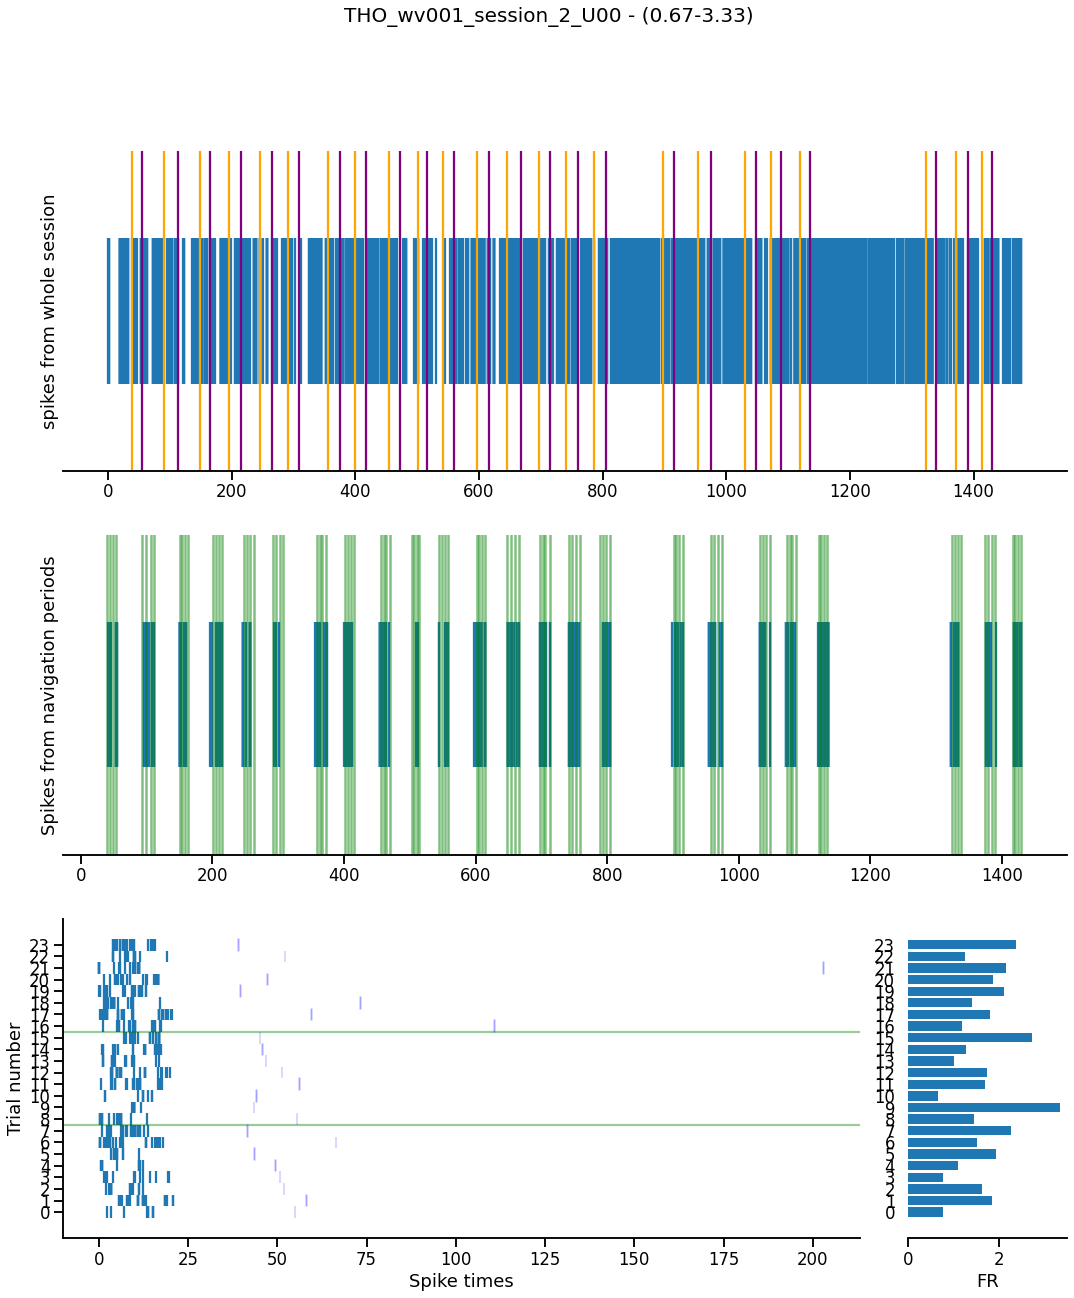

In [16]:
# Plot the unit report
plot_spikes_trial(spikes, spikes_trial, nav_stops_trial, nav_spikes_all, nav_starts, 
                      nav_stops, openings, name, frs, hlines)

## All units

In [ ]:
for nwbfilename in nwbfiles:
    nwbfile = NWBHDF5IO(str(PATHS['DATA'] / nwbfilename), 'r').read()
    
    nav_starts = nwbfile.trials.navigation_start[:]
    nav_stops = nwbfile.trials.navigation_stop[:]
    chest_openings = nwbfile.trials['chest_opening_time'][:]
    openings = nwbfile.trials.chest_opening_time[:]
    
    # Reset nav_stops per trial
    nav_stops_trial = [nav_stops[ind+1] - nav_stops[ind] for ind in range(len(nav_stops)-1)]
    nav_stops_trial = [nav_stops[0]] + nav_stops_trial
    
    # Check the number of units & keep indices
    n_units = len(nwbfile.units)
    keep_inds = np.where(nwbfile.units.keep[:])[0]
    n_keep = len(keep_inds)
    
    # Add hlines for each block of trials
    hlines = []
    if (len(nav_starts) >= 8) and (len(nav_starts) <= 16):
        hlines = [7.5]
    elif (len(nav_starts) > 16) and (len(nav_starts) <= 24):
        hlines = [7.5, 15.5]
    elif len(nav_starts) > 24:
        hlines = [7.5, 15.5, 23.5]
    
    for index in keep_inds:
        name = nwbfile.session_id + '_U' + str(index).zfill(2)
        spikes = nwbfile.units.get_unit_spike_times(index)
        spikes_trial = epoch_spikes_by_range(spikes, nav_starts, nav_stops, reset=True)
        tc_spikes = epoch_spikes_by_range(spikes, nav_starts, nav_stops, reset=False)
        
        # Compute the firing rate per trial
        nav_spikes = []
        frs = np.zeros(len(spikes_trial))
        for ind in range(len(spikes_trial)): 
            t_spikes = get_range(spikes, nav_starts[ind], nav_stops[ind])
            nav_spikes.append(t_spikes)
            nav_spikes_all = np.concatenate(nav_spikes).ravel()
            if len(tc_spikes[ind]) != 0: 
                frs[ind] = compute_firing_rate(tc_spikes[ind], start_time=nav_starts[ind], 
                                                stop_time=nav_stops[ind])
            else:
                frs[ind] = 0
        # Plot the unit report
        plot_spikes_trial(spikes, spikes_trial, nav_stops_trial, nav_spikes_all, nav_starts, 
                          nav_stops, openings, name, frs, hlines)